In [151]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated,List
from langgraph.graph import add_messages, StateGraph, END
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [152]:
load_dotenv()

True

In [192]:
class AgentState(TypedDict):
    messages: Annotated[List, add_messages]

In [193]:
search_tool=TavilySearchResults(max_results=2)

In [194]:
tools=[search_tool]

In [195]:
llmGemini=ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

In [196]:
llm_with_tools=llmGemini.bind_tools(tools=tools)

In [197]:
def model(state: AgentState):
    state["messages"]=[llm_with_tools.invoke(input=state["messages"])]
    return state
    

In [212]:
def tools_router(state:AgentState):
    last_message=state["messages"][-1]

    if hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0:
        return "tool_node"
    else:
        return "end"

In [213]:
tool_node=ToolNode(tools=tools,messages_key="messages")

In [214]:
graph=StateGraph(state_schema=AgentState)

In [215]:
graph.add_node(node="model",action=model)

In [216]:
graph.add_node(node="tool_node",action=tool_node)

In [217]:
graph.set_entry_point(key="model")

In [218]:
graph.add_conditional_edges(source="model",path=tools_router,path_map={"tool_node":"tool_node","end":END})

In [219]:
graph.add_edge(start_key="tool_node",end_key="model")

In [220]:
app=graph.compile()

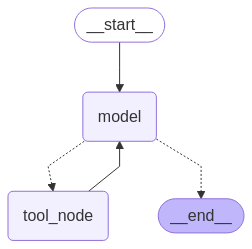

In [221]:
display(Image(data=app.get_graph(xray=True).draw_mermaid_png()))

In [222]:
input={
    "messages":["What's the current weather in Bangalore?"]
}

In [223]:
# app.invoke(input=input)

In [227]:
events=app.stream(input=input, stream_mode="values")

In [228]:
for event in events:
    print(event,"\n")

{'messages': [HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='9473f94b-0b40-4bfb-b0cc-b792e08e317c')]} 

{'messages': [HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='9473f94b-0b40-4bfb-b0cc-b792e08e317c'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Bangalore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run-6fdced52-6ed0-4243-8e73-5a2f85e05d9d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bangalore'}, 'id': 'd81a0fbf-73dd-4bec-95e7-136d3245db6e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 12, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}})]} 

{'messages'

In [229]:
events=app.stream(input=input, stream_mode="updates")

In [230]:
for event in events:
    print(event,"\n")

{'model': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Bangalore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run-707c68a0-3f68-4751-91c0-e137b86ef2b6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bangalore'}, 'id': 'eef29c9e-bd95-4a06-b9f7-533a7757dc90', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 12, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}})]}} 

{'tool_node': {'messages': [ToolMessage(content='[{"title": "Bengaluru Weather Forecast 6 May 2025 - Times of India", "url": "https://timesofindia.indiatimes.com/weather/bengaluru-weather-forecast-today/560001", "content": "Today\'s Weather in Bengaluru: In Bengaluru today, the weather is expected to be Fair with a maximu

In [232]:
input={
    "messages":["Hi how are you?"]
}

In [234]:
events=app.astream_events(input=input, version="v2")

In [235]:
async for event in events:
    print(event,"\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi how are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '03769367-de1c-46b6-b90a-5764ed0115b8', 'metadata': {}, 'parent_ids': []} 

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi how are you?', additional_kwargs={}, response_metadata={}, id='1e9320cd-2e30-4c08-b921-a8f0076eb3f8')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': 'a638e021-dd73-4e02-8b4c-1e180adc23a5', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:5e6f0f05-2921-46f3-415e-e9ab41d49c96'}, 'parent_ids': ['03769367-de1c-46b6-b90a-5764ed0115b8']} 

{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi how are you?', additional_kwargs={}, response_metadata={}, id='1e9320cd-2e30-4c08-b921-a8f0076eb3f8')]]}}, 'name': 'ChatGoogleGenerativeAI', 

In [243]:
events=app.astream_events(input=input, version="v2")

In [244]:
async for event in events:
    if event["event"]=="on_chat_model_stream":
        print(event['data']['chunk'].content,end="",flush=True)

I am doing well, thank you for asking. How can I help you today?